In [ ]:
!pip install langchain langchain-openai pandas
!pip install openai
!pip install nest-asyncio
!pip install langchain-experimental
!pip install langchain_core langchain-anthropic langgraph
!pip install faiss-cpu

In [ ]:
# Install package first
# We use uv for faster installation

# Google Colab is setting some uv-related environment variables, that seem to have broken with the a Colab update.
# The Colab team is tracking this internally (googlecolab/colabtools#5237).
# https://github.com/googlecolab/colabtools/issues/5237#issuecomment-2786440777
import os
os.environ["UV_CONSTRAINT"] = os.environ["UV_BUILD_CONSTRAINT"] = ""  # add this line to solve the uv related issue

!pip install uv
!uv pip install -q autogluon.timeseries --system --prerelease allow
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab


## if there seems to be inconsistency due to numpy & pandas versions, do the following
# !uv pip uninstall pandas numpy
!uv pip install -q --force-reinstall numpy==1.26.4 --system --prerelease allow
!uv pip install -q --force-reinstall pandas==2.2.2 --system --prerelease allow
## You may need to restart colab kernel

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [ ]:
# !pip install --upgrade langchain langchain-core langchain-openai openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.4/644.4 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.70.0
    Uninstalling openai-1.70.0:
      Successfully uninstalled openai-1.70.0


In [ ]:
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain_openai import OpenAI, ChatOpenAI
import nest_asyncio
import pandas as pd

from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.func import entrypoint, task

import re
from langchain.docstore.document import Document
import faiss
from langchain.chains import RetrievalQA
from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/GE_Capstone/AI Agent Workflow/

/content/drive/MyDrive/GE_Capstone/AI Agent Workflow


### Workflow to Handle Multiple Tasks in One Prompt

In [ ]:
from google.colab import files
import pandas as pd

uploaded = files.upload()


# df = pd.read_csv("subset.csv")  # Replace with your actual filename
df = pd.read_csv("reform_AirPassengersDataset_DARTS_144.csv")
df.head()

,item_id,timestamp,target
0,1,1949-01-01 00:00:00,112
1,1,1949-02-01 00:00:00,118
2,1,1949-03-01 00:00:00,132
3,1,1949-04-01 00:00:00,129
4,1,1949-05-01 00:00:00,121


In [ ]:
# df = df.drop('Slope', axis=1)
# df["datetime"] = pd.to_datetime(df["datetime"])
# df["timestamp"] = (df["datetime"] - df["datetime"].min()).dt.total_seconds()/3600

<ipython-input-5-346f1f8b5590>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["datetime"] = pd.to_datetime(df["datetime"])


In [ ]:
llm_4 = ChatOpenAI(
	api_key="replace with your api",
    model_name="gpt-4",
    temperature=0.7
)

llm_turbo = ChatOpenAI(
	api_key="replace with your api",
    model_name="gpt-3.5-turbo",
    temperature=0.7
)

In [ ]:
agent_threshold = create_pandas_dataframe_agent(llm_turbo, df, verbose=True, allow_dangerous_code=True)
agent_slope = create_pandas_dataframe_agent(llm_4, df, verbose=True, allow_dangerous_code=True)

In [ ]:
## route user input to the correct agent
class Route(BaseModel):
    step: Literal["slope", "exceedance", "separate"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm_4.with_structured_output(Route)


@task
def llm_call_1(input_: str):
    """Slope Calculation"""
    result = agent_slope.invoke(input_)
    return result


@task
def llm_call_2(input_: str):
    """Threshold Exceedance"""
    result = agent_threshold.invoke(input_)
    return result

@task
def llm_call_3(input_: str):
    """Split Prompt"""
    result = llm_4.invoke(input_)
    prompts = result.content.splitlines()
    all_results = []
    for prompt in prompts:
      if prompt == "":
        continue
      print(f"Sub-prompt: {prompt}")
      for step in router_workflow_2.stream(prompt, stream_mode="updates"):
        all_results.append(step)

    return all_results


def llm_call_router(input_: str):
    """Route the input to the appropriate node"""
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to slope, threshold, or separate based on the user's request."
            ),
            HumanMessage(content=input_),
        ]
    )
    return decision.step


# Create workflow
@entrypoint()
def router_workflow_1(input_: str):
    next_step = llm_call_router(input_)
    if next_step == "slope":
        llm_call = llm_call_1
    elif next_step == "exceedance":
        llm_call = llm_call_2
    elif next_step == "separate":
        llm_call = llm_call_3

    return  llm_call(input_).result()

@entrypoint()
def router_workflow_2(input_: str):
    next_step = llm_call_router(input_)
    if next_step == "slope":
        llm_call = llm_call_1
    elif next_step == "exceedance":
        llm_call = llm_call_2
    elif next_step == "separate":
        llm_call = llm_call_3

    return {
        llm_call.__name__: {
            "result": llm_call(input_).result()
        }
    }

/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1637: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [ ]:
for step in router_workflow_1.stream("Two prompts are in this sentence. Please separate and return them. What is the slope of values in the target column of df. Only return slope of target column, no explanation. Calculate the 95% for target column of df. Only return a list of numbers that exceed the 95% value, no explanation.", stream_mode="updates"):
    print(step)
    print("\n")

Sub-prompt: 1. What is the slope of values in the target column of df. Only return slope of target column, no explanation.


> Entering new AgentExecutor chain...
Thought: To find the slope of the values in the target column, we first need to turn the 'target' column into a list or array. After that, we can use the numpy's polyfit function to find the slope and the intercept of the line that best fits the data. The first value returned by the function is the slope and the second value is the intercept.
Action: python_repl_ast
Action Input: 
```python
import numpy as np

x = df.index
y = df['target']

slope, intercept = np.polyfit(x, y, 1)
slope
```2.657183908045976I now know the final answer.
Final Answer: The slope of the values in the target column of df is 2.657183908045976.

> Finished chain.
Sub-prompt: 2. Calculate the 95% for target column of df. Only return a list of numbers that exceed the 95% value, no explanation.


> Entering new AgentExecutor chain...
Thought: To calculate

In [ ]:
for step in router_workflow_2.stream("Two prompts are in this sentence. Please separate and return them. What is the slope of values in the target column of df. Only return slope of target column, no explanation. Calculate the 95% for target column of df. Only return a list of numbers that exceed the 95% value, no explanation.", stream_mode="updates"):
    print(step)
    print("\n")

Sub-prompt: 1) What is the slope of values in the target column of df. Only return slope of target column, no explanation.


> Entering new AgentExecutor chain...
Thought: To find the slope of the values in the target column, we need to perform a linear regression on the index of the dataframe and the target column. The slope of the regression line will give us the slope of the values in the target column. We can use the `linregress` function from the `scipy.stats` module to perform the linear regression.

Action: python_repl_ast
Action Input: 
```python
from scipy.stats import linregress

# Get the index values and target column values as lists
x = df.index.tolist()
y = df['target'].tolist()

# Perform linear regression and get the slope
slope, intercept, r_value, p_value, std_err = linregress(x, y)
slope
```2.657183908045977The slope of the values in the target column of the dataframe is approximately 2.657.
Final Answer: 2.657

> Finished chain.
Sub-prompt: 2) Calculate the 95% for 

In [ ]:
for step in router_workflow_1.stream("What is the slope of values in the target column of df. Only return slope of target column, no explanation. ", stream_mode="updates"):
    print(step)
    print("\n")



> Entering new AgentExecutor chain...
Thought: To find the slope of the values in the target column, we can use the numpy polyfit function. This function fits a polynomial of a specified degree to the data and returns the coefficients of the polynomial. In this case, we want a polynomial of degree 1, which is a straight line, and the coefficient of the x term will be the slope of the line.

Action: python_repl_ast
Action Input: 
```python
import numpy as np
slope, intercept = np.polyfit(df.index, df['target'], 1)
slope
```2.657183908045976I have calculated the slope of the values in the target column of the dataframe df.
Final Answer: 2.657183908045976

> Finished chain.
{'llm_call_1': {'input': 'What is the slope of values in the target column of df. Only return slope of target column, no explanation. ', 'output': '2.657183908045976'}}


{'router_workflow_1': {'input': 'What is the slope of values in the target column of df. Only return slope of target column, no explanation. ', 'ou

### LangGraph Workflow, datafile detected from prompt rather than pre-defined

In [ ]:
llm_4 = ChatOpenAI(
	api_key="replace with your api",
    model_name="gpt-4",
    temperature=0.7
)

llm_turbo = ChatOpenAI(
	api_key="replace with your api",
    model_name="gpt-3.5-turbo",
    temperature=0.7
)

In [ ]:
# agent_threshold = create_pandas_dataframe_agent(llm_turbo, df, verbose=True, allow_dangerous_code=True)
# agent_slope = create_pandas_dataframe_agent(llm_4, df, verbose=True, allow_dangerous_code=True)
def build_agent_from_prompt(llm, prompt: str):
    import re
    match = re.search(r"[\"'](?P<filename>[^\"']+\.csv)[\"']", prompt)
    if not match:
        raise ValueError("No CSV file name found in prompt.")
    file_path = match.group("filename")

    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        raise ValueError(f"Failed to load CSV file: {file_path}") from e

    agent = create_pandas_dataframe_agent(llm, df, verbose=True, allow_dangerous_code=True)
    return agent

In [ ]:
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.types import Command
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from pydantic import BaseModel, Field
from typing import Literal
import json

class Route(BaseModel):
    step: Literal["slope", "exceedance", "separate"] = Field(
        ..., description="The next step in the routing process"
    )

router = llm_4.with_structured_output(Route)

# ==== Supervisor Node ====
def supervisor_node(state: MessagesState) -> Command:
    user_msg = state["messages"][-1].content
    step = router.invoke([
        SystemMessage(content="Route the input to slope, threshold, forecasting, or separate based on the user's request."),
        HumanMessage(content=user_msg),
    ]).step
    return Command(update={"messages": state["messages"]}, goto=step)


# ==== Slope Node ====
def slope_worker_node(state: MessagesState) -> Command:
    prompt = state["messages"][-1].content
    agent = build_agent_from_prompt(llm_4, prompt)
    result = agent_slope.invoke(prompt)
    content = result.get("output", str(result))
    return Command(update={"messages": state["messages"] + [AIMessage(content=content)]}, goto=END)

# ==== Threshold Node ====
def threshold_worker_node(state: MessagesState) -> Command:
    prompt = state["messages"][-1].content
    agent = build_agent_from_prompt(llm_turbo, prompt)
    result = agent.invoke(prompt)
    content = result.get("output", str(result))
    return Command(update={"messages": state["messages"] + [AIMessage(content=content)]}, goto=END)

# ==== Separate Node ====
def separate_worker_node(state: MessagesState) -> Command:
    user_msg = state["messages"][-1].content

    result = llm_4.invoke(user_msg)
    prompts = result.content.splitlines()

    all_outputs = []
    for prompt in prompts:
        prompt = prompt.strip()
        if not prompt:
            continue
        print(f"[Separate] Sub-prompt: {prompt}")

        sub_state = {"messages": [HumanMessage(content=prompt)]}
        sub_result = graph.invoke(sub_state)

        if "messages" in sub_result and isinstance(sub_result["messages"], list):
            output_msg = sub_result["messages"][-1]
            if hasattr(output_msg, "content"):
                all_outputs.append(f"Prompt: {prompt}\nResult: {output_msg.content}")
            else:
                all_outputs.append(f"Prompt: {prompt}\nResult: [No content returned]")
        else:
            all_outputs.append(f"Prompt: {prompt}\nResult: [Invalid result structure]")

    summary = "\n\n".join(all_outputs)
    return Command(update={"messages": state["messages"] + [AIMessage(content=summary)]}, goto=END)

In [ ]:
builder = StateGraph(MessagesState)

builder.add_node("supervisor", supervisor_node)
builder.add_node("slope", slope_worker_node)
builder.add_node("exceedance", threshold_worker_node)
builder.add_node("separate", separate_worker_node)

builder.set_entry_point("supervisor")
builder.add_edge("slope", END)
builder.add_edge("exceedance", END)
builder.add_edge("separate", END)

graph = builder.compile()

Compiled graph id: 134086014345040
Mermaid graph id: 134086014345040


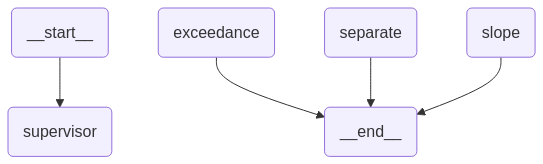

In [ ]:
from IPython.display import display, Image
print("Compiled graph id:", id(graph))
print("Mermaid graph id:", id(graph))
# print(graph.get_graph().draw_mermaid())
display(Image(graph.get_graph().draw_mermaid_png()))
# print(graph.get_graph().draw_mermaid())

In [ ]:
from langchain_core.messages import HumanMessage

state = {
    "messages": [
        HumanMessage(content="Use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the 95% for target column of df, then only return a list of numbers in the target column that exceed the 95% value, no explanation.")
    ]
}

# result = graph.invoke(state)
# print(result["messages"][-1].content)
for update in graph.stream(state, stream_mode="updates"):
    print(">>> Step executed:")
    if "node" in update:
        print(f"  Node: {update['node']}")
    if "messages" in update:
        for msg in update["messages"]:
            print(f"  Message: {getattr(msg, 'content', msg)}")
    print("-" * 40)

>>> Step executed:
----------------------------------------


> Entering new AgentExecutor chain...
Thought: I need to load the data from the CSV file into a pandas dataframe and then calculate the 95th percentile for the 'target' column in the dataframe.
Action: python_repl_ast
Action Input: df = pd.read_csv('reform_AirPassengersDataset_DARTS_144.csv')NameError: name 'pd' is not definedI forgot to import pandas before trying to use it.
Action: python_repl_ast
Action Input: import pandas as pdNow I can try loading the data and calculating the 95th percentile for the 'target' column.
Action: python_repl_ast
Action Input: df = pd.read_csv('reform_AirPassengersDataset_DARTS_144.csv')Now I can calculate the 95th percentile for the 'target' column and filter the dataframe based on that.
Action: python_repl_ast
Action Input: percentile_95 = df['target'].quantile(0.95)Now I can filter the dataframe to only include values in the 'target' column that exceed the 95th percentile value.
Action: py

In [ ]:
state = {
    "messages": [
        HumanMessage(content="Use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the slope of values in the target column of df, then return the slope of target column only, no explanation.")
    ]
}

# result = graph.invoke(state)
# print(result["messages"][-1].content)
for update in graph.stream(state, stream_mode="updates"):
    print(">>> Step executed:")
    if "node" in update:
        print(f"  Node: {update['node']}")
    if "messages" in update:
        for msg in update["messages"]:
            print(f"  Message: {getattr(msg, 'content', msg)}")
    print("-" * 40)

>>> Step executed:
----------------------------------------


> Entering new AgentExecutor chain...
Thought: The question asks for the slope of the values in the target column. This suggests a linear regression problem where we consider the target values as the dependent variable and the index (or time) as the independent variable. We can use numpy.polyfit to calculate the slope.

Action: python_repl_ast
Action Input: 
```python
import numpy as np

# Create an array representing the index values
x = np.array(df.index)

# Create an array representing the target values
y = np.array(df['target'])

# Use numpy's polyfit function to calculate the slope and intercept of the best fit line
slope, intercept = np.polyfit(x, y, 1)

slope
```2.657183908045976The slope of the best fit line for the target values is approximately 2.66.
Final Answer: 2.66

> Finished chain.
>>> Step executed:
----------------------------------------


In [ ]:
from langchain_core.messages import HumanMessage

initial_state = {
    "messages": [
        HumanMessage(content="Two prompts are in this sentence. Please separate and return them. Use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the slope of values in the target column of df and only return slope of target column, no explanation. Use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the 95% for target column of df. Only return a list of numbers that exceed the 95% value, no explanation.")
    ]
}

# result = graph.invoke(initial_state)
# print(result["messages"][-1].content)
for update in graph.stream(initial_state, stream_mode="updates"):
    print(">>> Step executed:")
    if "node" in update:
        print(f"  Node: {update['node']}")
    if "messages" in update:
        for msg in update["messages"]:
            print(f"  Message: {getattr(msg, 'content', msg)}")
    print("-" * 40)

>>> Step executed:
----------------------------------------
[Separate] Sub-prompt: 1) Use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the slope of values in the target column of df and only return slope of target column, no explanation.


> Entering new AgentExecutor chain...
Thought: To calculate the slope of the values in the target column, I'll need to do a linear regression. A simple way to do this in Python is using numpy's polyfit function, which can fit a polynomial of a specified degree to data and returns the coefficients of the polynomial. In this case, a degree of 1 is used to fit a straight line. The slope is the first coefficient returned by polyfit.
Action: python_repl_ast
Action Input: 
```python
import numpy as np

x = np.arange(len(df))
y = df['target']
slope, intercept = np.polyfit(x, y, 1)
slope
```2.657183908045976I have calculated the slope of the target column using numpy's polyfit for linear regression.
Final Answer: The slope of the target 

### Integrate with Chronos for Forecasting

In [ ]:
llm_4 = ChatOpenAI(
	api_key="replace with your api",
    model_name="gpt-4",
    temperature=0.7
)

llm_turbo = ChatOpenAI(
	api_key="replace with your api",
    model_name="gpt-3.5-turbo",
    temperature=0.7
)

In [ ]:
# agent_threshold = create_pandas_dataframe_agent(llm_turbo, df, verbose=True, allow_dangerous_code=True)
# agent_slope = create_pandas_dataframe_agent(llm_4, df, verbose=True, allow_dangerous_code=True)

In [ ]:
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.types import Command
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from pydantic import BaseModel, Field
from typing import Literal
import json

class Route(BaseModel):
    step: Literal["forecast", "threshold_exceedance", "slope_calculation", "separate"] = Field(
        ..., description="The next step in the routing process"
    )

router = llm_4.with_structured_output(Route)

# ==== Supervisor Node ====
def llm_supervisor_node(state: MessagesState) -> Command[str]:
    user_msg = state["messages"][-1].content
    step = router.invoke([
        SystemMessage(content="Route the input to forecast, threshold_exceedance, slope_calculation, or separate based on the user's request."),
        HumanMessage(content=user_msg),
    ]).step
    return Command(update={"messages": state["messages"]}, goto=step)

# ==== Forecast Node ====
def chronos_forecast_node(state: MessagesState) -> Command:
    user_msg = state["messages"][-1].content
    import re, json
    match = re.search(r"'([^']+\.csv)'", user_msg)
    pred_len_match = re.search(r"(\d+)\s+(?:days|steps)", user_msg)

    if not match or not pred_len_match:
        return Command(update={"messages": state["messages"] + [AIMessage(content="Error: Missing file path or prediction length.")]}, goto="end")

    file_path = match.group(1)
    pred_len = int(pred_len_match.group(1))

    df = pd.read_csv(file_path)[["item_id", "timestamp", "target"]]
    tsdf = TimeSeriesDataFrame.from_data_frame(df, id_column="item_id", timestamp_column="timestamp")
    train_data, test_data = tsdf.train_test_split(pred_len)
    predictor = TimeSeriesPredictor(prediction_length=pred_len).fit(train_data, presets="bolt_small")
    predictions = predictor.predict(train_data)
    leaderboard = predictor.leaderboard(test_data)
    model_name = leaderboard.iloc[0]["model"]
    mape = -leaderboard.iloc[0]["score_test"]

    predictions_df = predictions.to_data_frame().reset_index()
    preview = predictions_df[["item_id", "timestamp", "mean"]].tail(10).to_string(index=False)
    result = f"Top model: {model_name}, MAPE: {mape * 100:.2f}%\nForecast Preview:\n{preview}"

    return Command(update={"messages": state["messages"] + [AIMessage(content=result)]}, goto="end")


# ==== build agent for LangChain Pandas to use ====
def build_agent_from_prompt(llm, prompt: str):
    import re
    match = re.search(r"[\"'](?P<filename>[^\"']+\.csv)[\"']", prompt)
    if not match:
        raise ValueError("No CSV file name found in prompt.")
    file_path = match.group("filename")

    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        raise ValueError(f"Failed to load CSV file: {file_path}") from e

    agent = create_pandas_dataframe_agent(llm, df, verbose=True, allow_dangerous_code=True)
    return agent

# ==== Slope Node ====
def slope_agent_node(state: MessagesState) -> Command:
    prompt = state["messages"][-1].content
    agent = build_agent_from_prompt(llm_4, prompt)
    result = agent.invoke(prompt)
    content = result.get("output", str(result))
    return Command(update={"messages": state["messages"] + [AIMessage(content=content)]}, goto="end")

# ==== Threshold Node ====
def threshold_agent_node(state: MessagesState) -> Command:
    prompt = state["messages"][-1].content
    agent = build_agent_from_prompt(llm_turbo, prompt)
    result = agent.invoke(prompt)
    content = result.get("output", str(result))
    return Command(update={"messages": state["messages"] + [AIMessage(content=content)]}, goto="end")

# ==== Separate Node ====
def separate_worker_node(state: MessagesState) -> Command:
    user_msg = state["messages"][-1].content

    result = llm_4.invoke(user_msg)
    prompts = result.content.splitlines()

    all_outputs = []
    for prompt in prompts:
        prompt = prompt.strip()
        if not prompt:
            continue
        print(f"[Separate] Sub-prompt: {prompt}")

        sub_state = {"messages": [HumanMessage(content=prompt)]}
        sub_result = graph.invoke(sub_state)

        if "messages" in sub_result and isinstance(sub_result["messages"], list):
            output_msg = sub_result["messages"][-1]
            if hasattr(output_msg, "content"):
                all_outputs.append(f"Prompt: {prompt}\nResult: {output_msg.content}")
            else:
                all_outputs.append(f"Prompt: {prompt}\nResult: [No content returned]")
        else:
            all_outputs.append(f"Prompt: {prompt}\nResult: [Invalid result structure]")

    summary = "\n\n".join(all_outputs)
    return Command(update={"messages": state["messages"] + [AIMessage(content=summary)]}, goto="end")

In [ ]:
builder = StateGraph(MessagesState)

builder.add_node("supervisor", llm_supervisor_node)
builder.add_node("forecast", chronos_forecast_node)
builder.add_node("threshold_exceedance", threshold_agent_node)
builder.add_node("slope_calculation", slope_agent_node)
builder.add_node("separate", separate_worker_node)

builder.set_entry_point("supervisor")
builder.add_edge("forecast", END)
builder.add_edge("threshold_exceedance", END)
builder.add_edge("slope_calculation", END)
builder.add_edge("separate", END)

graph = builder.compile()

Compiled graph id: 134086013153616
Mermaid graph id: 134086013153616


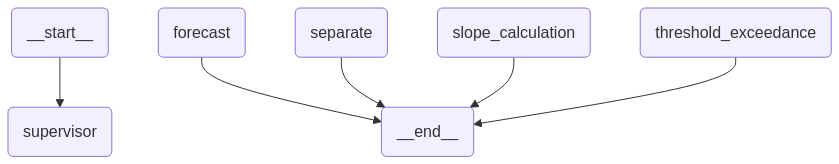

In [ ]:
from IPython.display import display, Image
print("Compiled graph id:", id(graph))
print("Mermaid graph id:", id(graph))
# print(graph.get_graph().draw_mermaid())
display(Image(graph.get_graph().draw_mermaid_png()))
# print(graph.get_graph().draw_mermaid())

#### invoke the agent

In [ ]:
# ==== threshold exceedance task ====
from langchain_core.messages import HumanMessage

state = {
    "messages": [
        HumanMessage(content="Use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the 95% threshold for target column of df, then only return a list of numbers in the target column that exceed the 95% value, no explanation.")
    ]
}

# result = graph.invoke(state)
# print(result["messages"][-1].content)
for update in graph.stream(state, stream_mode="updates"):
    print(">>> Step executed:")
    if "node" in update:
        print(f"  Node: {update['node']}")
    if "messages" in update:
        for msg in update["messages"]:
            print(f"  Message: {getattr(msg, 'content', msg)}")
    print("-" * 40)

>>> Step executed:
----------------------------------------


> Entering new AgentExecutor chain...
Thought: I need to load the data from the CSV file and calculate the 95% threshold for the target column in the dataframe.
Action: python_repl_ast
Action Input: df = pd.read_csv('reform_AirPassengersDataset_DARTS_144.csv')NameError: name 'pd' is not definedI forgot to import the pandas library before using it.
Action: python_repl_ast
Action Input: import pandas as pdNow that I have imported pandas, I can load the data from the CSV file and proceed with the calculations.
Action: python_repl_ast
Action Input: df = pd.read_csv('reform_AirPassengersDataset_DARTS_144.csv')I need to calculate the 95th percentile value for the 'target' column in the dataframe.
Action: python_repl_ast
Action Input: percentile_95 = df['target'].quantile(0.95)Now, I need to filter the dataframe to only include values in the 'target' column that exceed the 95th percentile value.
Action: python_repl_ast
Action Input

In [ ]:
# ==== slope calculation task ====
state = {
    "messages": [
        HumanMessage(content="Use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the slope of values in the target column of df, then return the slope of target column only, no explanation.")
    ]
}

# result = graph.invoke(state)
# print(result["messages"][-1].content)
for update in graph.stream(state, stream_mode="updates"):
    print(">>> Step executed:")
    if "node" in update:
        print(f"  Node: {update['node']}")
    if "messages" in update:
        for msg in update["messages"]:
            print(f"  Message: {getattr(msg, 'content', msg)}")
    print("-" * 40)

>>> Step executed:
----------------------------------------


> Entering new AgentExecutor chain...
Thought: To calculate the slope of values in the target column, I need to perform a linear regression on this data set. The slope of the regression line is the value we need. I can use the `linregress` function from the `scipy.stats` library to do this.
Action: python_repl_ast
Action Input: 
```python
from scipy.stats import linregress

# Add an index column to the dataframe for calculation of slope
df['index'] = df.index

# Perform linear regression
slope, _, _, _, _ = linregress(df['index'], df['target'])

slope
```2.657183908045977I have calculated the slope of the target column.
Final Answer: The slope of the target column is approximately 2.657.

> Finished chain.
>>> Step executed:
----------------------------------------


results from previous two tasks are both correct.

In [ ]:
# ==== forecasting task ====
initial_state = {
    "messages": [
        HumanMessage(content="Please forecast the next 24 days using the file 'reform_AirPassengersDataset_DARTS_144.csv'.")
    ]
}

result = graph.invoke(initial_state)
print(result["messages"][-1].content)


Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/AI Agent Workflow/AutogluonModels/ag-20250413_020546'
=================== System Info ===================
AutoGluon Version:  1.2.1b20250412
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.95 GB / 12.67 GB (86.4%)
Disk Space Avail:   63.85 GB / 107.72 GB (59.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred tim

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


Top model: Chronos[bolt_small], MAPE: 5.04%
Forecast Preview:
 item_id  timestamp       mean
       1 1960-03-01 414.699951
       1 1960-04-01 419.955566
       1 1960-05-01 428.213074
       1 1960-06-01 483.538208
       1 1960-07-01 525.270935
       1 1960-08-01 521.030457
       1 1960-09-01 468.151520
       1 1960-10-01 409.785828
       1 1960-11-01 384.249237
       1 1960-12-01 402.730347


In [ ]:
# ==== threshold exceedance & slope calculation task in one prompt ====

initial_state = {
    "messages": [
        HumanMessage(content="Two prompts are in this sentence. Please separate and return them. Use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the slope of values in the target column of df and only return slope of target column, no explanation. Use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the 95% for target column of df. Only return a list of numbers that exceed the 95% value, no explanation.")
    ]
}

# result = graph.invoke(initial_state)
# print(result["messages"][-1].content)
for update in graph.stream(initial_state, stream_mode="updates"):
    print(">>> Step executed:")
    if "node" in update:
        print(f"  Node: {update['node']}")
    if "messages" in update:
        for msg in update["messages"]:
            print(f"  Message: {getattr(msg, 'content', msg)}")
    print("-" * 40)

>>> Step executed:
----------------------------------------
[Separate] Sub-prompt: 1. Use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the slope of values in the target column of df and only return slope of target column, no explanation.


> Entering new AgentExecutor chain...
Thought: To calculate the slope of the values in the 'target' column, we first need to ensure that the data is sorted in ascending order by the 'timestamp' column. After sorting the data, we can use the numpy polyfit function to fit a line to the data points and get the slope of the line. The numpy polyfit function takes three arguments: x-coordinates of the data points, y-coordinates of the data points, and the degree of the polynomial to fit. We can set the degree to 1 to fit a line to the data points. The polyfit function returns the coefficients of the polynomial in order of decreasing powers. The first coefficient is the slope of the line.

Action: python_repl_ast
Action Input: 
```
impo

In [ ]:
# ==== threshold exceedance & slope calculation & forecasting task in one prompt ====

initial_state = {
    "messages": [
        HumanMessage(content="Three prompts are in this sentence. Please separate and return them. First use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the slope of values in the target column of df and only return slope of target column, no explanation. Secondly use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the 95% for target column of df, and only return a list of numbers that exceed the 95% value, no explanation. Finally forecast the next 24 days using the file 'reform_AirPassengersDataset_DARTS_144.csv'.")
    ]
}

result = graph.invoke(initial_state)
print(result["messages"][-1].content)
# for update in graph.stream(initial_state, stream_mode="updates"):
#     print(">>> Step executed:")
#     if "node" in update:
#         print(f"  Node: {update['node']}")
#     if "messages" in update:
#         for msg in update["messages"]:
#             print(f"  Message: {getattr(msg, 'content', msg)}")
#     print("-" * 40)

[Separate] Sub-prompt: 1. Use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the slope of values in the target column of df and only return slope of target column, no explanation.


> Entering new AgentExecutor chain...
Thought: To calculate the slope of a line, we use the formula (y2 - y1) / (x2 - x1). Here, x is the index of the dataframe and y is the target value. We can get the values of y and x from the dataframe, df. 

Action: python_repl_ast
Action Input: 
```python
import numpy as np
y = df['target'].values
x = np.arange(len(y))
slope = (y[-1] - y[0]) / (x[-1] - x[0])
slope
```2.237762237762238I have successfully calculated the slope of the target column.
Final Answer: 2.237762237762238

> Finished chain.
[Separate] Sub-prompt: 2. Use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the 95% for target column of df, and only return a list of numbers that exceed the 95% value, no explanation.


> Entering new AgentExecutor chain...
Thought: We 

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/AI Agent Workflow/AutogluonModels/ag-20250413_021011'
=================== System Info ===================
AutoGluon Version:  1.2.1b20250412
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.21 GB / 12.67 GB (80.6%)
Disk Space Avail:   63.63 GB / 107.72 GB (59.1%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred tim

Prompt: 1. Use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the slope of values in the target column of df and only return slope of target column, no explanation.
Result: 2.237762237762238

Prompt: 2. Use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the 95% for target column of df, and only return a list of numbers that exceed the 95% value, no explanation.
Result: [491, 505, 548, 559, 535, 622, 606, 508]

Prompt: 3. Forecast the next 24 days using the file 'reform_AirPassengersDataset_DARTS_144.csv'.
Result: Top model: Chronos[bolt_small], MAPE: 5.04%
Forecast Preview:
 item_id  timestamp       mean
       1 1960-03-01 414.699951
       1 1960-04-01 419.955566
       1 1960-05-01 428.213074
       1 1960-06-01 483.538208
       1 1960-07-01 525.270935
       1 1960-08-01 521.030457
       1 1960-09-01 468.151520
       1 1960-10-01 409.785828
       1 1960-11-01 384.249237
       1 1960-12-01 402.730347


### Integrate with text analysis

In [ ]:
llm_4 = ChatOpenAI(
	api_key="replace with your api",
    model_name="gpt-4",
    temperature=0.7
)

llm_turbo = ChatOpenAI(
	api_key="replace with your api",
    model_name="gpt-3.5-turbo",
    temperature=0.7
)

llm_o3mini = ChatOpenAI(
	api_key="replace with your api",
    model_name="o3-mini"
)

In [ ]:
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.types import Command
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from pydantic import BaseModel, Field
from typing import Literal
import json

class Route(BaseModel):
    step: Literal["forecast", "threshold_exceedance", "slope_calculation", "separate", "text_analysis"] = Field(
        ..., description="The next step in the routing process"
    )

router = llm_4.with_structured_output(Route)

# ==== Supervisor Node ====
def llm_supervisor_node(state: MessagesState) -> Command[str]:
    user_msg = state["messages"][-1].content
    step = router.invoke([
        SystemMessage(content="Route the input to forecast, threshold_exceedance, slope_calculation, text_analysis, or separate based on the user's request."),
        HumanMessage(content=user_msg),
    ]).step
    return Command(update={"messages": state["messages"]}, goto=step)

# ==== Forecast Node ====
def chronos_forecast_node(state: MessagesState) -> Command:
    user_msg = state["messages"][-1].content
    import re, json
    match = re.search(r"'([^']+\.csv)'", user_msg)
    pred_len_match = re.search(r"(\d+)\s+(?:days|steps)", user_msg)

    if not match or not pred_len_match:
        return Command(update={"messages": state["messages"] + [AIMessage(content="Error: Missing file path or prediction length.")]}, goto="end")

    file_path = match.group(1)
    pred_len = int(pred_len_match.group(1))

    df = pd.read_csv(file_path)[["item_id", "timestamp", "target"]]
    tsdf = TimeSeriesDataFrame.from_data_frame(df, id_column="item_id", timestamp_column="timestamp")
    train_data, test_data = tsdf.train_test_split(pred_len)
    predictor = TimeSeriesPredictor(prediction_length=pred_len).fit(train_data, presets="bolt_small")
    predictions = predictor.predict(train_data)
    leaderboard = predictor.leaderboard(test_data)
    model_name = leaderboard.iloc[0]["model"]
    mape = -leaderboard.iloc[0]["score_test"]

    predictions_df = predictions.to_data_frame().reset_index()
    preview = predictions_df[["item_id", "timestamp", "mean"]].tail(10).to_string(index=False)
    result = f"Top model: {model_name}, MAPE: {mape * 100:.2f}%\nForecast Preview:\n{preview}"

    return Command(update={"messages": state["messages"] + [AIMessage(content=result)]}, goto="end")


# ==== build agent for LangChain Pandas to use ====
def build_agent_from_prompt(llm, prompt: str):
    import re
    match = re.search(r"[\"'](?P<filename>[^\"']+\.csv)[\"']", prompt)
    if not match:
        raise ValueError("No CSV file name found in prompt.")
    file_path = match.group("filename")

    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        raise ValueError(f"Failed to load CSV file: {file_path}") from e

    agent = create_pandas_dataframe_agent(llm, df, verbose=True, allow_dangerous_code=True)
    return agent

# ==== Slope Node ====
def slope_agent_node(state: MessagesState) -> Command:
    prompt = state["messages"][-1].content
    agent = build_agent_from_prompt(llm_4, prompt)
    result = agent.invoke(prompt)
    content = result.get("output", str(result))
    return Command(update={"messages": state["messages"] + [AIMessage(content=content)]}, goto="end")

# ==== Threshold Node ====
def threshold_agent_node(state: MessagesState) -> Command:
    prompt = state["messages"][-1].content
    agent = build_agent_from_prompt(llm_turbo, prompt)
    result = agent.invoke(prompt)
    content = result.get("output", str(result))
    return Command(update={"messages": state["messages"] + [AIMessage(content=content)]}, goto="end")

# === Text Analysis Node ===
def text_analysis_node(state: MessagesState) -> Command:
    user_msg = state["messages"][-1].content
    match = re.search(r"'([^']+\.txt)'", user_msg)
    if not match:
        return Command(update={"messages": state["messages"] + [AIMessage(content="Error: Missing .txt file in prompt.")]}, goto="end")
    file_path = match.group(1)

    try:
        with open(file_path, "r", encoding="utf-8") as f:
            content = f.read()
    except Exception as e:
        return Command(update={"messages": state["messages"] + [AIMessage(content=f"Failed to load file: {e}")]} , goto="end")

    documents = [Document(page_content=content)]

    embedding_model = OpenAIEmbeddings(openai_api_key="replace with your api")
    vectorstore = FAISS.from_documents(documents, embedding_model)
    qa_chain = RetrievalQA.from_chain_type(llm=llm_o3mini, retriever=vectorstore.as_retriever())

    query = state["messages"][-1].content
    result = qa_chain.invoke(query)
    return Command(update={"messages": state["messages"] + [AIMessage(content=result['result'])]}, goto="end")

# ==== Separate Node ====
def separate_worker_node(state: MessagesState) -> Command:
    user_msg = state["messages"][-1].content

    result = llm_4.invoke(user_msg)
    prompts = result.content.splitlines()

    all_outputs = []
    for prompt in prompts:
        prompt = prompt.strip()
        if not prompt:
            continue
        print(f"[Separate] Sub-prompt: {prompt}")

        sub_state = {"messages": [HumanMessage(content=prompt)]}
        sub_result = graph.invoke(sub_state)

        if "messages" in sub_result and isinstance(sub_result["messages"], list):
            output_msg = sub_result["messages"][-1]
            if hasattr(output_msg, "content"):
                all_outputs.append(f"Prompt: {prompt}\nResult: {output_msg.content}")
            else:
                all_outputs.append(f"Prompt: {prompt}\nResult: [No content returned]")
        else:
            all_outputs.append(f"Prompt: {prompt}\nResult: [Invalid result structure]")

    summary = "\n\n".join(all_outputs)
    return Command(update={"messages": state["messages"] + [AIMessage(content=summary)]}, goto="end")

/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1660: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [ ]:
builder = StateGraph(MessagesState)

builder.add_node("supervisor", llm_supervisor_node)
builder.add_node("forecast", chronos_forecast_node)
builder.add_node("threshold_exceedance", threshold_agent_node)
builder.add_node("slope_calculation", slope_agent_node)
builder.add_node("text_analysis", text_analysis_node)
builder.add_node("separate", separate_worker_node)

builder.set_entry_point("supervisor")
builder.add_edge("forecast", END)
builder.add_edge("threshold_exceedance", END)
builder.add_edge("slope_calculation", END)
builder.add_edge("text_analysis", END)
builder.add_edge("separate", END)

graph = builder.compile()

Compiled graph id: 134499259869200
Mermaid graph id: 134499259869200


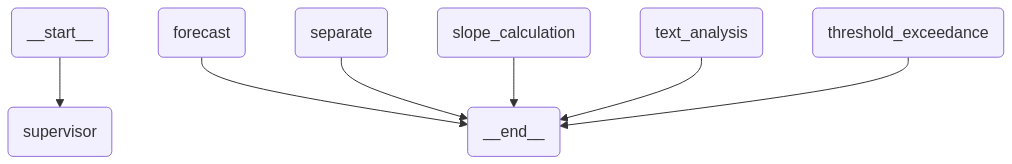

In [ ]:
from IPython.display import display, Image
print("Compiled graph id:", id(graph))
print("Mermaid graph id:", id(graph))
# print(graph.get_graph().draw_mermaid())
display(Image(graph.get_graph().draw_mermaid_png()))
# print(graph.get_graph().draw_mermaid())

#### invoke the agent

In [ ]:
# ==== threshold exceedance task ====
from langchain_core.messages import HumanMessage

state = {
    "messages": [
        HumanMessage(content="Use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the 95% threshold for target column of df, then only return a list of numbers in the target column that exceed the 95% value, no explanation.")
    ]
}

# result = graph.invoke(state)
# print(result["messages"][-1].content)
for update in graph.stream(state, stream_mode="updates"):
    print(">>> Step executed:")
    if "node" in update:
        print(f"  Node: {update['node']}")
    if "messages" in update:
        for msg in update["messages"]:
            print(f"  Message: {getattr(msg, 'content', msg)}")
    print("-" * 40)

>>> Step executed:
----------------------------------------


> Entering new AgentExecutor chain...
Thought: I need to load the data from the file and calculate the 95% threshold for the target column in the dataframe `df`.

Action: python_repl_ast
Action Input: df['target'].quantile(0.95)488.14999999999986Now I need to filter the target column based on the 95% threshold.

Action: python_repl_ast
Action Input: df[df['target'] > df['target'].quantile(0.95)]['target'].tolist()[491, 505, 548, 559, 535, 622, 606, 508]I now know the final answer.

Final Answer: [491, 505, 548, 559, 535, 622, 606, 508]

> Finished chain.
>>> Step executed:
----------------------------------------


In [ ]:
# ==== slope calculation task ====
state = {
    "messages": [
        HumanMessage(content="Use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the slope of values in the target column of df, then return the slope of target column only, no explanation.")
    ]
}

# result = graph.invoke(state)
# print(result["messages"][-1].content)
for update in graph.stream(state, stream_mode="updates"):
    print(">>> Step executed:")
    if "node" in update:
        print(f"  Node: {update['node']}")
    if "messages" in update:
        for msg in update["messages"]:
            print(f"  Message: {getattr(msg, 'content', msg)}")
    print("-" * 40)

>>> Step executed:
----------------------------------------


> Entering new AgentExecutor chain...
Thought: The question is asking to calculate the slope of values in the target column of the dataframe df. To do this, we will first need to ensure that the data in the target column is numeric and then use a linear regression model to calculate the slope. 

Action: python_repl_ast
Action Input: 
```python
import pandas as pd
from sklearn.linear_model import LinearRegression

# Load the dataframe
df = pd.read_csv('reform_AirPassengersDataset_DARTS_144.csv')

# Check the data type of target column
print(df['target'].dtypes)
```int64
The target column is of type int64, which is numeric. So, we can proceed with the calculation of the slope. The slope of a linear regression model is calculated by fitting the model to the data points. The independent variable will be the index of the dataframe and the dependent variable will be the 'target' column. 

Action: python_repl_ast
Action Input: 
```

results from previous two tasks are both correct.

In [ ]:
# ==== forecasting task ====
initial_state = {
    "messages": [
        HumanMessage(content="Please forecast the next 24 days using the file 'reform_AirPassengersDataset_DARTS_144.csv'.")
    ]
}

result = graph.invoke(initial_state)
print(result["messages"][-1].content)


Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/AI Agent Workflow/AutogluonModels/ag-20250415_232846'
=================== System Info ===================
AutoGluon Version:  1.2.1b20250415
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.84 GB / 12.67 GB (85.6%)
Disk Space Avail:   63.56 GB / 107.72 GB (59.0%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred tim

Top model: Chronos[bolt_small], MAPE: 5.04%
Forecast Preview:
 item_id  timestamp       mean
       1 1960-03-01 414.699951
       1 1960-04-01 419.955566
       1 1960-05-01 428.213074
       1 1960-06-01 483.538208
       1 1960-07-01 525.270935
       1 1960-08-01 521.030457
       1 1960-09-01 468.151520
       1 1960-10-01 409.785828
       1 1960-11-01 384.249237
       1 1960-12-01 402.730347


In [ ]:
# ==== Text Analysis task ====
initial_state = {
    "messages": [
        HumanMessage(content="Extract all instances where maintenance was performed from 'short.txt' based on the description column, do not include routine maintenance, give me the record ID and dates where maintenance was performed as list where each element is quoted.")
    ]
}

result = graph.invoke(initial_state)
print(result["messages"][-1].content)

["R091: 2024-12-13", "R092: 2024-06-06", "R093: 2025-01-22", "R094: 2024-01-27", "R095: 2025-02-05", "R096: 2024-02-20", "R097: 2024-11-01", "R098: 2024-09-08", "R099: 2024-07-16", "R100: 2024-09-01"]


In [ ]:
# ==== threshold exceedance & slope calculation task in one prompt ====

initial_state = {
    "messages": [
        HumanMessage(content="Two prompts are in this sentence. Please separate and return them. Use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the slope of values in the target column of df and only return slope of target column, no explanation. Use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the 95% for target column of df. Only return a list of numbers that exceed the 95% value, no explanation.")
    ]
}

# result = graph.invoke(initial_state)
# print(result["messages"][-1].content)
for update in graph.stream(initial_state, stream_mode="updates"):
    print(">>> Step executed:")
    if "node" in update:
        print(f"  Node: {update['node']}")
    if "messages" in update:
        for msg in update["messages"]:
            print(f"  Message: {getattr(msg, 'content', msg)}")
    print("-" * 40)

>>> Step executed:
----------------------------------------
[Separate] Sub-prompt: "Use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the slope of values in the target column of df and only return slope of target column, no explanation."


> Entering new AgentExecutor chain...
Thought: To calculate the slope of the values in the target column, I need to perform a linear regression on the data. The slope of the regression line is the coefficient of the independent variable. In this case, the independent variable is the index of the dataframe, which can be considered as time. 

The slope can be calculated using numpy's polyfit function, which fits a polynomial of a specified degree to the data and returns the coefficients of the polynomial. For a linear regression, we'll use a polynomial of degree 1.

Action: python_repl_ast
Action Input: 
```python
import numpy as np

# Use np.polyfit to fit a degree 1 polynomial to the data. The first argument is the x values (the i

In [ ]:
# ==== text analysis & threshold exceedance & slope calculation & forecasting task in one prompt ====

initial_state = {
    "messages": [
        HumanMessage(content="Four prompts are in this sentence. Please separate and return them. Firstly extract all instances where maintenance was performed from file 'short.txt' based on the description column, do not include routine maintenance, return record ID and dates where maintenance was performed as list. Secondly use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the slope of values in the target column of df and only return slope of target column, no explanation. Thirdly use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the 95% for target column of df, and only return a list of numbers that exceed the 95% value, no explanation. Finally forecast the next 24 days using the file 'reform_AirPassengersDataset_DARTS_144.csv'.")
    ]
}

result = graph.invoke(initial_state)
print(result["messages"][-1].content)
# for update in graph.stream(initial_state, stream_mode="updates"):
#     print(">>> Step executed:")
#     if "node" in update:
#         print(f"  Node: {update['node']}")
#     if "messages" in update:
#         for msg in update["messages"]:
#             print(f"  Message: {getattr(msg, 'content', msg)}")
#     print("-" * 40)

[Separate] Sub-prompt: 1. Extract all instances where maintenance was performed from file 'short.txt' based on the description column, do not include routine maintenance, return record ID and dates where maintenance was performed as list.
[Separate] Sub-prompt: 2. Use the file 'reform_AirPassengersDataset_DARTS_144.csv' to calculate the slope of values in the target column of df and only return slope of target column, no explanation.


> Entering new AgentExecutor chain...
Thought: To calculate the slope of values in the target column, we need to perform a linear regression on the target values with respect to their corresponding indices. We can use the `numpy.polyfit` function to perform the linear regression. This function returns the coefficients of the polynomial that best fits the given data using the method of least squares. Since we are interested in a linear fit, we should use a degree of 1. The first coefficient returned by `numpy.polyfit` will be the slope of the line.

Actio

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/AI Agent Workflow/AutogluonModels/ag-20250415_233523'
=================== System Info ===================
AutoGluon Version:  1.2.1b20250415
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.44 GB / 12.67 GB (82.4%)
Disk Space Avail:   63.56 GB / 107.72 GB (59.0%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred tim

Prompt: 1. Extract all instances where maintenance was performed from file 'short.txt' based on the description column, do not include routine maintenance, return record ID and dates where maintenance was performed as list.
Result: Below is the list of non‐routine maintenance records (showing Record ID and Date) extracted from file "short.txt":

• R091 – 2024‑12‑13 (Gearbox realigned after detecting vibration anomalies)  
• R092 – 2024‑06‑06 (Air filter replaced after detecting reduced airflow efficiency)  
• R093 – 2025‑01‑22 (Faulty relay switch replaced after intermittent failures observed)  
• R094 – 2024‑01‑27 (Pump seals replaced to resolve a detected minor leak)  
• R095 – 2025‑02‑05 (System recalibrated following minor deviations in sensor readings)  
• R096 – 2024‑02‑20 (Faulty relay switch replaced after intermittent failures observed)  
• R097 – 2024‑11‑01 (Air filter replaced after detecting reduced airflow efficiency)  
• R098 – 2024‑09‑08 (Technicians replaced a worn‑out 